In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

/home/shrey/miniconda3/envs/LLMIdentifiersEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-10 14:46:37.569472: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 14:46:37.577846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746881197.588690   15866 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746881197.591881   15866 cud

In [ ]:
# Load data
folder_path = "results/base/"
data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, "r") as f:
                    entry = json.load(f)
                    data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Skipped invalid JSON: {file_path} ({e})")

print(f"Loaded {len(data)} valid JSON result files from '{folder_path}' and its subfolders.")

Loaded 145 valid JSON result files from 'results/' and its subfolders.


In [3]:
justifications = []

for entry in data:
    for agent_id in [0, 1]:
        model_name = entry.get(f"model_general_name_{agent_id}", f"model_{agent_id}")
        answer = entry.get(f"agent_{agent_id}_answer", "")
        
        if isinstance(answer, str) and answer.strip():
            justifications.append({
                "agent_model": model_name,
                "text": answer.strip().lower().split("2.")[0][2:]
            })

# Create a DataFrame
df_just = pd.DataFrame(justifications)
df_just.head()

model = SentenceTransformer('sentence-t5-base')
embeddings = model.encode(df_just['text'].tolist())

# PCA dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
df_just['x'] = reduced[:, 0]
df_just['y'] = reduced[:, 1]

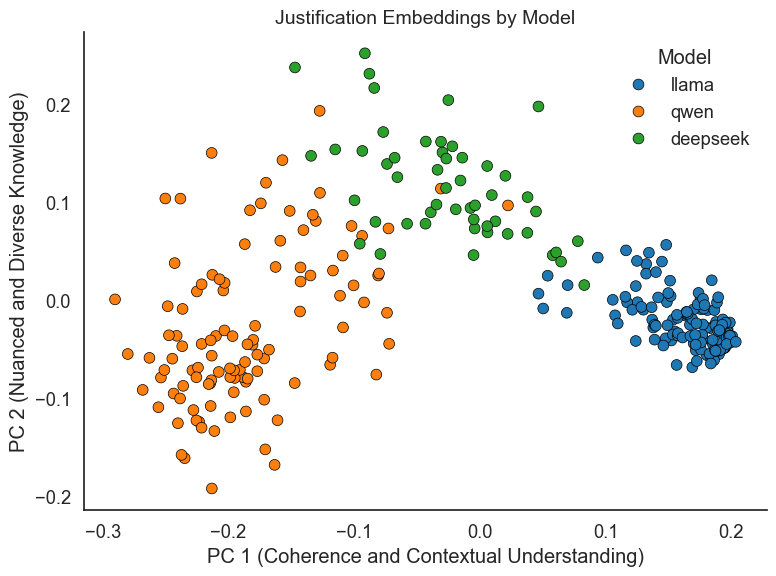

In [4]:
# Set style
sns.set(style="white", font_scale=1.2)
palette = sns.color_palette("tab10", n_colors=df_just['agent_model'].nunique())

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_just,
    x="x",
    y="y",
    hue="agent_model",
    palette=palette,
    s=60,
    edgecolor="black",
    linewidth=0.5
)

plt.title("Justification Embeddings by Model", fontsize=14)
plt.xlabel("PC 1 (Coherence and Contextual Understanding)")
plt.ylabel("PC 2 (Nuanced and Diverse Knowledge)")
plt.legend(title="Model", loc="best", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("4.4.png", dpi=300)
plt.show()

In [5]:
# Helper function
def show_similarities(df, embeddings, axis_label, top=True):
    direction = "max" if top else "min"
    anchor_idx = df[axis_label].idxmax() if top else df[axis_label].idxmin()
    anchor_vector = embeddings[anchor_idx].reshape(1, -1)
    similarities = cosine_similarity(anchor_vector, embeddings).flatten()

    label = f"Most {'similar' if top else 'dissimilar'} to extreme {axis_label.upper()} value ({direction}):"
    print(f"\n{label}")
    sorted_indices = similarities.argsort()[::-1] if top else similarities.argsort()
    for idx in sorted_indices[1:6]:  # skip self
        print("-", df.iloc[idx]["text"])

# Run for PC1 (x)
show_similarities(df_just, embeddings, "x", top=True)
show_similarities(df_just, embeddings, "x", top=False)

# Run for PC2 (y)
show_similarities(df_just, embeddings, "y", top=True)
show_similarities(df_just, embeddings, "y", top=False)


Most similar to extreme X value (max):
-  the other agent's responses demonstrate a high level of coherence, contextual understanding, and ability to engage in complex discussions, which are characteristic of advanced language models. the agent's ability to understand and respond to nuanced questions, as well as its capacity to introduce new ideas and perspectives, suggest a high level of linguistic and cognitive sophistication.

-  the other agent's responses demonstrate a high level of coherence, context understanding, and ability to engage in complex discussions, which are characteristic of advanced language models. the agent's ability to understand and respond to nuanced questions, as well as its capacity for self-awareness and reflection, suggest a high level of sophistication.

-  the other agent's responses demonstrate a high level of coherence, contextual understanding, and ability to engage in complex discussions, which are characteristic of advanced language models. the agen